In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

#from utils import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = np.genfromtxt('./train.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_y = data[:,0]
data = np.delete(data, (0), axis=1)
data_np_x = data / 255


pos = int(data_np_x.shape[0] * 0.75)

train_np_y = data_np_y[:pos]
train_np_x = data_np_x[:pos]
test_np_y = data_np_y[pos:]
test_np_x = data_np_x[pos:]

print ("Y: {}".format(train_np_y[:10]))

Y: [1. 0. 1. 4. 0. 0. 7. 3. 5. 3.]


In [3]:
print (data_np_x.shape, data_np_y.shape)
print (train_np_x.shape, train_np_y.shape)
print (test_np_x.shape, test_np_y.shape)

(42000, 784) (42000,)
(31500, 784) (31500,)
(10500, 784) (10500,)


In [4]:
print (test_np_x.shape, test_np_y.shape)

(10500, 784) (10500,)


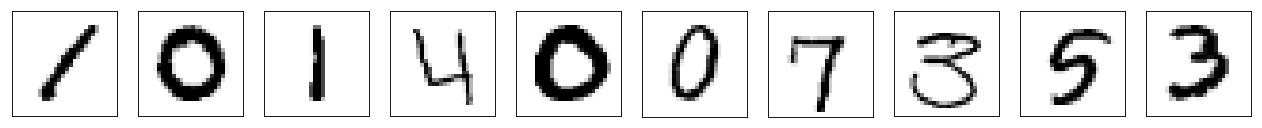

[1. 0. 1. 4. 0. 0. 7. 3. 5. 3.]


In [5]:
fig = plt.figure(figsize=(20,10), dpi=80)
shape = (1,10)
for j in range(10):
    ax = fig.add_subplot(shape[0], shape[1], j+1)
    image = train_np_x[j].reshape(28,28)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

print (train_np_y[:10])

In [6]:
def normalize(x):
    x = (x - 0.1307) / 0.3081    
    return x

In [7]:
train_x = torch.Tensor(np.expand_dims(normalize(train_np_x), axis=1))
train_y = torch.LongTensor(train_np_y)

test_x = torch.Tensor(np.expand_dims(normalize(test_np_x), axis=1))
test_y = torch.LongTensor(test_np_y)

In [8]:
def loader(x, y, batch_size=32):
    for i in range(0, x.size(0) - 1, batch_size):
        data = x[i:i+batch_size]
        if data.shape[0] == batch_size:
            data = data.reshape(batch_size, 1, 28, 28)
            targets = y[i:i+batch_size]

            yield data, targets
    

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []        
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):        
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [12]:
def train(epoch, models, log=None):
    train_size = len(train_x)
    for batch_idx, (data, target) in enumerate(loader(train_x, train_y)):
        for model in models.values():                             
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [13]:
def test(models, log=None):
    test_size = len(test_x)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader(test_x, test_y):
            output = {k: m(data) for k, m in models.items()}           
            for k, m in models.items():     
                #print (output[k].shape, target.shape)
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [14]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
 
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [15]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [16]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_log)

Train Epoch: 1 [0/31500 (0%)]	Losses bn: 2.319179 drop: 2.357496 plain: 2.348156
Train Epoch: 1 [6400/31500 (1%)]	Losses bn: 1.630361 drop: 2.118411 plain: 2.077665
Train Epoch: 1 [12800/31500 (1%)]	Losses bn: 1.325848 drop: 1.859936 plain: 1.758649
Train Epoch: 1 [19200/31500 (2%)]	Losses bn: 0.824835 drop: 1.160721 plain: 1.058992
Train Epoch: 1 [25600/31500 (3%)]	Losses bn: 0.829483 drop: 1.164378 plain: 1.114301
Train Epoch: 1 [31488/31500 (3%)]	Losses bn: 0.422958 drop: 0.523231 plain: 0.473664


/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
bn: Loss: 0.5980	Accuracy: 9607.0/10500 (91%)
drop: Loss: 0.7540	Accuracy: 8763.0/10500 (83%)
plain: Loss: 0.7050	Accuracy: 8908.0/10500 (85%)

Train Epoch: 2 [0/31500 (0%)]	Losses bn: 0.505012 drop: 0.652800 plain: 0.596863
Train Epoch: 2 [6400/31500 (1%)]	Losses bn: 0.379468 drop: 0.420178 plain: 0.390461
Train Epoch: 2 [12800/31500 (1%)]	Losses bn: 0.507827 drop: 0.684961 plain: 0.656615
Train Epoch: 2 [19200/31500 (2%)]	Losses bn: 0.273590 drop: 0.296539 plain: 0.278426
Train Epoch: 2 [25600/31500 (3%)]	Losses bn: 0.393888 drop: 0.646640 plain: 0.634070
Train Epoch: 2 [31488/31500 (3%)]	Losses bn: 0.190162 drop: 0.246321 plain: 0.225759
Test set:
bn: Loss: 0.3013	Accuracy: 9910.0/10500 (94%)
drop: Loss: 0.4087	Accuracy: 9449.0/10500 (90%)
plain: Loss: 0.3902	Accuracy: 9491.0/10500 (90%)

Train Epoch: 3 [0/31500 (0%)]	Losses bn: 0.196939 drop: 0.305009 plain: 0.288510
Train Epoch: 3 [6400/31500 (1%)]	Losses bn: 0.172002 drop: 0.183864 plain: 0.167041
Train Epoch: 3 [12800/

Train Epoch: 14 [6400/31500 (1%)]	Losses bn: 0.015319 drop: 0.017511 plain: 0.021090
Train Epoch: 14 [12800/31500 (1%)]	Losses bn: 0.068063 drop: 0.143815 plain: 0.153096
Train Epoch: 14 [19200/31500 (2%)]	Losses bn: 0.037086 drop: 0.036615 plain: 0.045039
Train Epoch: 14 [25600/31500 (3%)]	Losses bn: 0.127183 drop: 0.103556 plain: 0.108167
Train Epoch: 14 [31488/31500 (3%)]	Losses bn: 0.015959 drop: 0.058334 plain: 0.050207
Test set:
bn: Loss: 0.0580	Accuracy: 10311.0/10500 (98%)
drop: Loss: 0.0830	Accuracy: 10261.0/10500 (98%)
plain: Loss: 0.0833	Accuracy: 10248.0/10500 (98%)

Train Epoch: 15 [0/31500 (0%)]	Losses bn: 0.010241 drop: 0.023149 plain: 0.016843
Train Epoch: 15 [6400/31500 (1%)]	Losses bn: 0.014384 drop: 0.016887 plain: 0.020012
Train Epoch: 15 [12800/31500 (1%)]	Losses bn: 0.064825 drop: 0.133849 plain: 0.143902
Train Epoch: 15 [19200/31500 (2%)]	Losses bn: 0.035159 drop: 0.034495 plain: 0.042656
Train Epoch: 15 [25600/31500 (3%)]	Losses bn: 0.127114 drop: 0.094581 plain

Train Epoch: 26 [25600/31500 (3%)]	Losses bn: 0.120502 drop: 0.050954 plain: 0.059729
Train Epoch: 26 [31488/31500 (3%)]	Losses bn: 0.005867 drop: 0.023386 plain: 0.025043
Test set:
bn: Loss: 0.0429	Accuracy: 10355.0/10500 (99%)
drop: Loss: 0.0564	Accuracy: 10305.0/10500 (98%)
plain: Loss: 0.0571	Accuracy: 10317.0/10500 (98%)

Train Epoch: 27 [0/31500 (0%)]	Losses bn: 0.004566 drop: 0.009251 plain: 0.006739
Train Epoch: 27 [6400/31500 (1%)]	Losses bn: 0.009685 drop: 0.011820 plain: 0.012080
Train Epoch: 27 [12800/31500 (1%)]	Losses bn: 0.032983 drop: 0.077237 plain: 0.076301
Train Epoch: 27 [19200/31500 (2%)]	Losses bn: 0.018893 drop: 0.019894 plain: 0.024502
Train Epoch: 27 [25600/31500 (3%)]	Losses bn: 0.118459 drop: 0.049108 plain: 0.057954
Train Epoch: 27 [31488/31500 (3%)]	Losses bn: 0.005548 drop: 0.021834 plain: 0.023836
Test set:
bn: Loss: 0.0424	Accuracy: 10357.0/10500 (99%)
drop: Loss: 0.0553	Accuracy: 10310.0/10500 (98%)
plain: Loss: 0.0561	Accuracy: 10320.0/10500 (98%)

Tra

Train Epoch: 39 [6400/31500 (1%)]	Losses bn: 0.006785 drop: 0.008914 plain: 0.009175
Train Epoch: 39 [12800/31500 (1%)]	Losses bn: 0.015598 drop: 0.050268 plain: 0.038398
Train Epoch: 39 [19200/31500 (2%)]	Losses bn: 0.011783 drop: 0.015697 plain: 0.015988
Train Epoch: 39 [25600/31500 (3%)]	Losses bn: 0.070991 drop: 0.035209 plain: 0.044203
Train Epoch: 39 [31488/31500 (3%)]	Losses bn: 0.003357 drop: 0.010771 plain: 0.014278
Test set:
bn: Loss: 0.0387	Accuracy: 10365.0/10500 (99%)
drop: Loss: 0.0472	Accuracy: 10344.0/10500 (99%)
plain: Loss: 0.0484	Accuracy: 10331.0/10500 (98%)

Train Epoch: 40 [0/31500 (0%)]	Losses bn: 0.002848 drop: 0.005830 plain: 0.004034
Train Epoch: 40 [6400/31500 (1%)]	Losses bn: 0.006627 drop: 0.008696 plain: 0.008984
Train Epoch: 40 [12800/31500 (1%)]	Losses bn: 0.014696 drop: 0.048471 plain: 0.036233
Train Epoch: 40 [19200/31500 (2%)]	Losses bn: 0.011211 drop: 0.015451 plain: 0.015550
Train Epoch: 40 [25600/31500 (3%)]	Losses bn: 0.066656 drop: 0.034367 plain

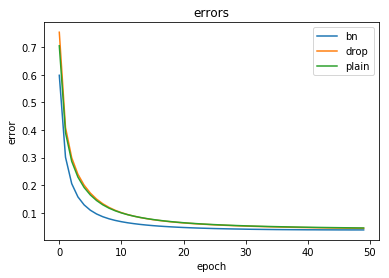

In [17]:
plot_graphs(test_log, 'loss')

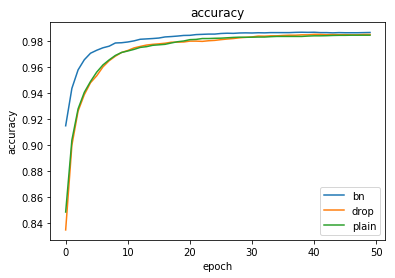

In [18]:
plot_graphs(test_log, 'accuracy')

##Расчет

In [19]:
data = np.genfromtxt('./test.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_x = data / 255

testing_x = torch.Tensor(np.expand_dims(normalize(data_np_x), axis=1))
testing_y = torch.LongTensor(np.zeros((testing_x.shape[0], 1)))

In [20]:
print (testing_x.shape)

torch.Size([28000, 1, 784])


In [21]:
answers = np.empty((0, 10))
model = models['bn']
print (model)

for batch_idx, (data, target) in enumerate(loader(testing_x, testing_y)):
    output = model(data)  
    output_np = output.detach().numpy()        
    answers = np.vstack((answers, output_np))
        
print (answers.shape)

Net(
  (_conv1): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
  )
  (_conv2): ConvLayer(
    (model): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Sigmoid()
    )
  )
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=1568, out_features=10, bias=True)
    )
  )
)
(28000, 10)


In [26]:
vals = np.argmax(answers, axis=1)

In [27]:
print (answers[:100])

[[-5.12488651e+00 -1.16979609e+01  1.17131557e+01 -5.37578058e+00
  -8.31176376e+00 -1.09081621e+01 -1.34402914e+01 -4.28746128e+00
  -7.84575081e+00 -1.00317526e+01]
 [ 6.96432972e+00 -1.35306473e+01 -3.80551410e+00 -7.74131393e+00
  -1.45859861e+01 -2.54134369e+00 -4.08026028e+00 -6.29842377e+00
  -7.99108171e+00 -9.28692245e+00]
 [-1.35510426e+01 -1.14046307e+01 -7.60599947e+00 -7.64140844e+00
   4.67250943e-02 -9.16571903e+00 -1.28538885e+01 -6.83837461e+00
  -4.51762295e+00  8.58169079e+00]
 [ 1.72356701e+00 -1.55118017e+01 -1.08282626e+00 -4.59631681e+00
  -7.06376934e+00 -7.98744965e+00 -7.97513676e+00 -1.46969581e+00
  -9.23403740e+00 -1.17659724e+00]
 [-7.34492588e+00 -1.17528381e+01 -6.07341170e-01  4.36626577e+00
  -1.14333391e+01 -7.63504934e+00 -1.01330757e+01 -7.76082563e+00
  -1.51367474e+00 -7.65570545e+00]
 [-1.04503775e+01 -1.17438173e+01 -4.93470144e+00 -5.25151157e+00
  -5.87223005e+00 -5.37248993e+00 -1.39909563e+01  5.12942410e+00
  -9.35096073e+00 -2.54206133e+00

In [28]:
print (vals[:1000])

[2 0 9 0 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6 2 5
 5 1 6 7 7 4 9 8 7 8 2 6 7 6 8 8 3 8 2 1 2 2 0 4 1 7 0 0 0 1 9 0 1 6 5 8 8
 2 8 9 9 2 3 5 4 1 0 9 2 4 3 6 7 2 0 6 6 1 4 3 9 7 4 0 9 2 0 7 3 0 5 0 8 0
 0 4 7 1 7 1 1 3 3 3 7 2 8 6 3 8 7 8 4 3 5 6 0 0 0 3 1 3 6 4 3 4 5 5 8 7 7
 2 8 4 3 5 6 5 3 7 5 7 8 3 0 4 5 1 2 7 6 3 0 2 7 8 6 1 3 7 4 1 2 4 8 5 2 4
 9 2 1 6 0 6 1 4 9 6 0 9 7 6 9 1 9 0 9 9 0 8 4 6 2 0 9 3 6 3 2 1 6 3 4 2 3
 1 2 2 0 4 6 1 0 0 4 9 1 7 3 2 3 8 6 8 6 2 8 5 5 4 8 3 5 9 7 1 3 8 4 5 1 4
 5 6 3 3 5 7 0 6 8 3 1 6 0 6 3 9 5 1 5 8 4 0 9 2 0 5 3 7 1 9 9 5 7 7 9 9 6
 3 0 3 3 6 9 8 2 6 3 7 1 4 5 8 5 9 0 0 3 8 4 1 8 4 1 1 9 8 4 5 1 5 3 6 3 1
 3 0 9 0 0 6 0 6 3 1 8 6 0 6 5 2 2 6 7 7 2 5 8 3 9 2 7 8 6 3 8 4 2 3 8 1 6
 4 8 7 9 7 6 9 5 3 7 6 5 5 4 2 6 2 1 3 7 1 7 9 9 6 1 1 1 7 3 9 7 6 1 1 1 9
 3 8 5 5 0 4 1 2 3 1 1 3 5 9 6 6 5 3 1 4 7 4 7 4 8 5 2 6 1 3 9 5 0 8 4 7 4
 4 4 1 5 3 9 9 7 6 9 5 9 2 3 5 6 6 7 5 0 5 1 7 4 4 1 1 4 9 5 6 0 1 3 1 0 4
 8 1 2 7 9 4 8 3 7 7 4 2 

In [29]:
with open("submission.txt", "w") as fout:
    fout.write("ImageId,Label\n")
    for i, val in enumerate(vals):
        fout.write("{},{}\n".format(str(i+1), str(val)))
        